In [80]:
import os
import sys
import igl
import torch
import subprocess
import numpy as np 
import open3d as o3d
import pandas as pd
import shapeworks as sw
import meshplot as mp
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from sklearn.decomposition import PCA

from ipywidgets import interact, widgets

sys.path.append('../../../utils/')
from sap_score import sap

# Original Particles

## Save original particle reconstrustion meshes - left

In [2]:
orig_dir = 'mesh_left/'
if not os.path.exists(orig_dir):
    os.makedirs(orig_dir)

recon_dir = 'reconstruction_left/'
if not os.path.exists(recon_dir):
    os.makedirs(recon_dir)

meshes = sorted(glob("groomed/meshes/data/*left.vtk"))
particles = sorted(glob("shape_model/hippocampus_particles/*left_local.particles"))

for i, mesh_path in tqdm(enumerate(meshes)):
    mesh_name = mesh_path.split("\\")[-1].replace('.vtk', "")
    
    mesh = sw.Mesh(mesh_path)
    mesh.write(f"{orig_dir}{mesh_name}.ply")
    particle = sw.ParticleSystem([particles[i]]).ShapeAsPointSet(0)    
    
    warper = sw.MeshWarper()
    warper.generateWarp(mesh, particle)
    warped_mesh = warper.buildMesh(particle)
    
    warped_mesh.write(f"{recon_dir}{mesh_name}.ply")

511it [14:37,  1.72s/it]


## Save original particle reconstrustion meshes - left

In [3]:
orig_dir = 'mesh_right/'
if not os.path.exists(orig_dir):
    os.makedirs(orig_dir)

recon_dir = 'reconstruction_right/'
if not os.path.exists(recon_dir):
    os.makedirs(recon_dir)

meshes = sorted(glob("groomed/meshes/data/*right.vtk"))
particles = sorted(glob("shape_model/hippocampus_particles/*right_local.particles"))

for i, mesh_path in tqdm(enumerate(meshes)):
    mesh_name = mesh_path.split("\\")[-1].replace('.vtk', "")
    
    mesh = sw.Mesh(mesh_path)
    mesh.write(f"{orig_dir}{mesh_name}.ply")
    particle = sw.ParticleSystem([particles[i]]).ShapeAsPointSet(0)    
    
    warper = sw.MeshWarper()
    warper.generateWarp(mesh, particle)
    warped_mesh = warper.buildMesh(particle)
    
    warped_mesh.write(f"{recon_dir}{mesh_name}.ply")

511it [14:45,  1.73s/it]


## Hausdorff distance - left + right

In [4]:
hausdorff_distances = []
left_originals = sorted(glob("./mesh_left/*.ply"))
#left_originals = os.listdir("mesh_left/")
left_reconstructions = sorted(glob("./reconstruction_left/*.ply"))
#left_reconstructions = os.listdir("reconstruction_left/")

right_originals = sorted(glob("./mesh_right/*.ply"))
#right_originals = os.listdir("mesh_right/")
right_reconstructions = sorted(glob("./reconstruction_right/*.ply"))
#right_reconstructions = os.listdir("reconstruction_right/")

for i in tqdm(range(len(left_originals))):
    left_mesh_o = o3d.io.read_triangle_mesh(left_originals[i])
    left_vertices_o = np.asarray(left_mesh_o.vertices)
    left_faces_o = np.asarray(left_mesh_o.triangles)
    left_mesh_r = o3d.io.read_triangle_mesh(left_reconstructions[i])
    left_vertices_r = np.asarray(left_mesh_r.vertices)
    left_faces_r = np.asarray(left_mesh_r.triangles)
    left_dist = igl.hausdorff(left_vertices_o, left_faces_o, left_vertices_r, left_faces_r)
    
    right_mesh_o = o3d.io.read_triangle_mesh(right_originals[i])
    right_vertices_o = np.asarray(right_mesh_o.vertices)
    right_faces_o = np.asarray(right_mesh_o.triangles)
    right_mesh_r = o3d.io.read_triangle_mesh(right_reconstructions[i])
    right_vertices_r = np.asarray(right_mesh_r.vertices)
    right_faces_r = np.asarray(right_mesh_r.triangles)
    right_dist = igl.hausdorff(right_vertices_o, right_faces_o, right_vertices_r, right_faces_r)
    
    hausdorff_distances.append(left_dist+right_dist)

100%|████████████████████████████████████████████████████████████████████████████████| 511/511 [01:29<00:00,  5.74it/s]


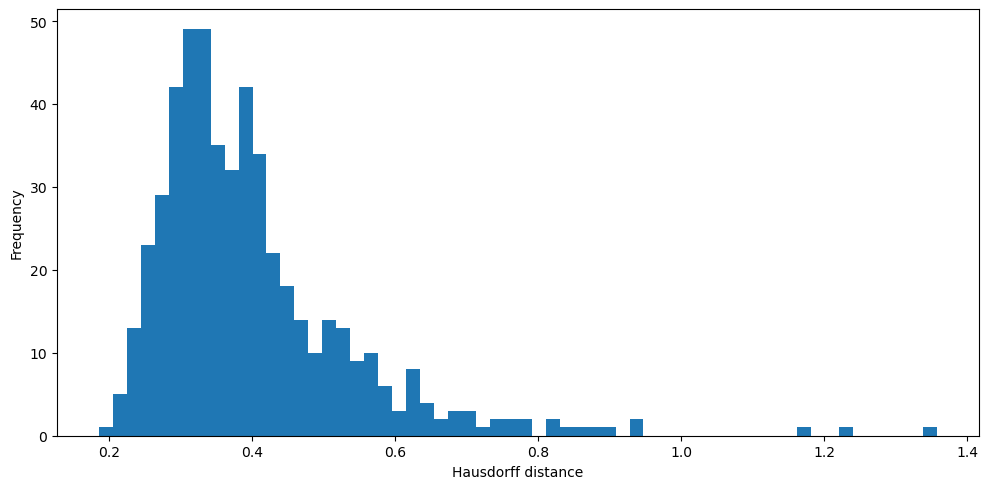

In [5]:
plt.figure(figsize=(10, 5))
plt.hist(hausdorff_distances, bins=60)
plt.xlabel("Hausdorff distance")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figures/hausdorff.png")
plt.show()

## Plot worst reconstruction

In [6]:
shading = {"wireframe":True, "wire_width": 1, "wire_color": "yellow"}

idx = np.argmax(hausdorff_distances)
error = np.max(hausdorff_distances)

left_vertices_o, left_faces_o = igl.read_triangle_mesh(left_originals[idx])
left_vertices_r, left_faces_r = igl.read_triangle_mesh(left_reconstructions[idx])

right_vertices_o, right_faces_o = igl.read_triangle_mesh(right_originals[idx])
right_vertices_r, right_faces_r = igl.read_triangle_mesh(right_reconstructions[idx])

print("[INFO]: Original: red | Reconstruction: gray")
print(f"[INFO]: Index of worst reconstruction: {idx}")
print(f"[INFO]: Reconstruction error: {error}")

p = mp.plot(v=left_vertices_o, f=left_faces_o, c=np.array([0.7,0.1,0.1])) #shading=shading)
p.add_mesh(v=left_vertices_r, f=left_faces_r, c=np.array([0.9,0.9,0.9]))
p.add_mesh(v=right_vertices_o, f=right_faces_o, c=np.array([0.7,0.1,0.1])) #shading=shading)
p.add_mesh(v=right_vertices_r, f=right_faces_r, c=np.array([0.9,0.9,0.9]))
p.save("figures/worst_reconstruction.png")

[INFO]: Original: red | Reconstruction: gray
[INFO]: Index of worst reconstruction: 193
[INFO]: Reconstruction error: 1.3574935140627709


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(90.463401…

Plot saved to file figures/worst_reconstruction.png.html.


# Load labels

In [3]:
df = pd.read_csv("demographics.csv", delimiter=";")

files = glob("data/*.nii")

filenames = []
for filename in files:
    filename = filename.split("\\")[-1].replace("_standard.nii", "")
    filenames.append(filename)
    
for filename in filenames:
    if not filename in df.subject.to_list():
        print(f"There is no label for: {filename}")

df[df.subject == "ab300_257"]

,subject,age,gender,subject_id,isManual
237,ab300_257,73,F,257,0


# PCA Particles

In [176]:
num_particles = 2048

In [177]:
# left particles
particles_list = []

for particles_path in tqdm(glob(f"shape_model_{num_particles}/hippocampus_particles/*left_local.particles")):
    particles_list.append(sw.ParticleSystem([particles_path]).ShapeAsPointSet(0).flatten())       
    
particles_array = np.array(particles_list)

# right particles
right_particles_list = []

for particles_path in tqdm(glob(f"shape_model_{num_particles}/hippocampus_particles/*right_local.particles")):
    right_particles_list.append(sw.ParticleSystem([particles_path]).ShapeAsPointSet(0).flatten())       
    
right_particles_array = np.array(right_particles_list)

100%|███████████████████████████████████████████████████████████████████████████| 511/511 [00:02<00:00, 174.70it/s]


In [178]:
# left PCA
pca = PCA(n_components=16)
pca.fit(particles_array)
pca_latent = pca.transform(particles_array)
recon_particles_array = pca.inverse_transform(pca_latent).reshape(pca_latent.shape[0], -1, 3)

# right PCA
pca = PCA(n_components=16)
pca.fit(right_particles_array)
right_pca_latent = pca.transform(right_particles_array)
right_recon_particles_array = pca.inverse_transform(right_pca_latent).reshape(right_pca_latent.shape[0], -1, 3)

In [179]:
# left SAP
codes = np.delete(pca_latent, 237, 0)
factors = df.age.to_numpy().reshape(-1,1)
print(f"SAP score: {sap(factors, codes):.4f}")

# right SAP
codes = np.delete(right_pca_latent, 237, 0)
factors = df.age.to_numpy().reshape(-1,1)
print(f"SAP score: {sap(factors, codes):.4f}")

SAP score: 0.1329
SAP score: 0.1053


In [180]:
# left meshes
mesh_list = []

for mesh_path in tqdm(glob("groomed/*left.vtk")):
    mesh_list.append(sw.Mesh(mesh_path))                      
    
# right meshes
right_mesh_list = []

for mesh_path in tqdm(glob("groomed/*right.vtk")):
    right_mesh_list.append(sw.Mesh(mesh_path))   

100%|████████████████████████████████████████████████████████████████████████████| 511/511 [00:18<00:00, 27.60it/s]


In [ ]:
distances = []
distances_left = []
distances_right = []
left_recon_mesh_list = []
right_recon_mesh_list = []

for subject in tqdm(range(len(mesh_list))):

    # left
    warper = sw.MeshWarper()
    warper.generateWarp(mesh_list[subject], recon_particles_array[subject])
    warped_mesh = warper.buildMesh(recon_particles_array[subject])
    left_recon_mesh_list.append(warped_mesh)
    # dist_left = igl.hausdorff(mesh_list[subject].points(), mesh_list[subject].faces(), warped_mesh.points(), warped_mesh.faces())
    dist_left = np.mean(np.sqrt(igl.point_mesh_squared_distance(mesh_list[subject].points(), warped_mesh.points(), warped_mesh.faces())[0]))
    distances_left.append(dist_left)
    
    # right
    warper = sw.MeshWarper()
    warper.generateWarp(right_mesh_list[subject], right_recon_particles_array[subject])
    warped_mesh = warper.buildMesh(right_recon_particles_array[subject])
    right_recon_mesh_list.append(warped_mesh)
    # dist_right = igl.hausdorff(right_mesh_list[subject].points(), right_mesh_list[subject].faces(), warped_mesh.points(), warped_mesh.faces())
    dist_right = np.mean(np.sqrt(igl.point_mesh_squared_distance(right_mesh_list[subject].points(), warped_mesh.points(), warped_mesh.faces())[0]))    
    distances_right.append(dist_right)
    
    distances.append(dist_left+dist_right)

torch.save(distances_left, f"shape_model_{num_particles}/distances_left.pt")
torch.save(distances_right, f"shape_model_{num_particles}/distances_right.pt")
torch.save(distances, f"shape_model_{num_particles}/distances.pt")

 36%|███████████████████████████▎                                                | 184/511 [10:08<19:14,  3.53s/it]

In [163]:
pd.DataFrame(distances_left).describe()

,0
count,511.000000
mean,0.296570
std,0.052929
min,0.187529
25%,0.262667
50%,0.291013
75%,0.318679
max,0.675147


In [164]:
pd.DataFrame(distances_right).describe()

,0
count,511.000000
mean,0.292148
std,0.048728
min,0.191282
25%,0.259350
50%,0.285430
75%,0.320677
max,0.526615


In [165]:
pd.DataFrame(distances).describe()

,0
count,511.000000
mean,0.588719
std,0.084695
min,0.422650
25%,0.533934
50%,0.576405
75%,0.631127
max,1.072224


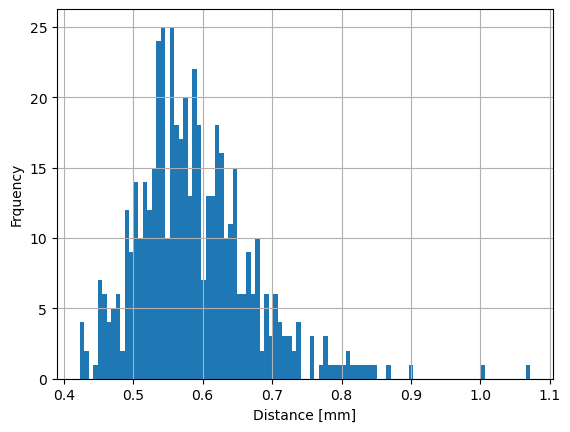

In [166]:
plt.hist(np.array(distances), bins=100)
plt.xlabel("Distance [mm]")
plt.ylabel("Frquency")
plt.grid(True)
plt.show()

## Plot worst reconstruction

In [167]:
maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'jet']
shading = {"colormap": maps[5]}

subject = np.argmax(distances)

# print("[INFO]: Original: yellow | Reconstruction: red")
print(f"[INFO]: Index of worst reconstruction: {subject}")
print(f"[INFO]: Distance: {distances[subject]:.2f} mm")

left_dist = np.sqrt(igl.point_mesh_squared_distance(mesh_list[subject].points(), left_recon_mesh_list[subject].points(), left_recon_mesh_list[subject].faces())[0])
print(f"[INFO]: Mean dist left: {np.mean(left_dist):.2f}mm")
print(f"[INFO]: Max dist left: {np.max(left_dist):.2f}mm")
right_dist = np.sqrt(igl.point_mesh_squared_distance(right_mesh_list[subject].points(), right_recon_mesh_list[subject].points(), right_recon_mesh_list[subject].faces())[0])
print(f"[INFO]: Mean dist right: {np.mean(right_dist):.2f}mm")
print(f"[INFO]: Max dist right: {np.max(right_dist):.2f}mm")

#p = mp.plot(v=recon_mesh_list[subject].points(), f=recon_mesh_list[subject].faces(), c=np.array([0.7,0.1,0.1]))
p = mp.plot(v=mesh_list[subject].points(), f=mesh_list[subject].faces(), c=left_dist, shading=shading)

#p.add_mesh(v=right_recon_mesh_list[subject].points(), f=right_recon_mesh_list[subject].faces(), c=np.array([0.7,0.1,0.1]))
p.add_mesh(v=right_mesh_list[subject].points(), f=right_mesh_list[subject].faces(), c=right_dist, shading=shading)


[INFO]: Index of worst reconstruction: 337
[INFO]: Distance: 1.07 mm
[INFO]: Mean dist left: 0.68mm
[INFO]: Max dist left: 5.14mm
[INFO]: Mean dist right: 0.40mm
[INFO]: Max dist right: 1.58mm


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(94.060298…

1

## Plot best reconstruction

In [168]:
maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'jet']
shading = {"colormap": maps[5]}

subject = np.argmin(distances)

# print("[INFO]: Original: yellow | Reconstruction: red")
print(f"[INFO]: Index of best reconstruction: {subject}")
print(f"[INFO]: Distance: {distances[subject]:.2f} mm")

left_dist = np.sqrt(igl.point_mesh_squared_distance(mesh_list[subject].points(), left_recon_mesh_list[subject].points(), left_recon_mesh_list[subject].faces())[0])
print(f"[INFO]: Mean dist left: {np.mean(left_dist):.2f}mm")
print(f"[INFO]: Max dist left: {np.max(left_dist):.2f}mm")
right_dist = np.sqrt(igl.point_mesh_squared_distance(right_mesh_list[subject].points(), right_recon_mesh_list[subject].points(), right_recon_mesh_list[subject].faces())[0])
print(f"[INFO]: Mean dist right: {np.mean(right_dist):.2f}mm")
print(f"[INFO]: Max dist right: {np.max(right_dist):.2f}mm")

#p = mp.plot(v=recon_mesh_list[subject].points(), f=recon_mesh_list[subject].faces(), c=np.array([0.7,0.1,0.1]))
p = mp.plot(v=mesh_list[subject].points(), f=mesh_list[subject].faces(), c=left_dist, shading=shading)

#p.add_mesh(v=right_recon_mesh_list[subject].points(), f=right_recon_mesh_list[subject].faces(), c=np.array([0.7,0.1,0.1]))
p.add_mesh(v=right_mesh_list[subject].points(), f=right_mesh_list[subject].faces(), c=right_dist, shading=shading)


[INFO]: Index of best reconstruction: 51
[INFO]: Distance: 0.42 mm
[INFO]: Mean dist left: 0.22mm
[INFO]: Max dist left: 1.22mm
[INFO]: Mean dist right: 0.20mm
[INFO]: Max dist right: 1.28mm


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(90.484249…

1

## Summary plot: Reconstruction error over Number of Particles

In [169]:
# mean_dist_left_128 = 1.9119
mean_dist_left_128 = np.mean(torch.load(f"shape_model_{num_particles}/distances_left.pt"))
# mean_dist_right_128 = 1.8809
mean_dist_right_128 = np.mean(torch.load(f"shape_model_{num_particles}/distances_right.pt"))
# mean_dist_overall_128 = 3.7928
mean_dist_overall_128 = torch.load(f"shape_model_{num_particles}/distances.pt")
mean_dist_left_256 = np.mean(torch.load(f"shape_model_{num_particles}/distances_left.pt"))
mean_dist_right_256 = np.mean(torch.load(f"shape_model_{num_particles}/distances_right.pt"))
mean_dist_overall_256 = torch.load(f"shape_model_{num_particles}/distances.pt")
mean_dist_left_512 = np.mean(torch.load(f"shape_model_{num_particles}/distances_left.pt"))
mean_dist_right_512 = np.mean(torch.load(f"shape_model_{num_particles}/distances_right.pt"))
mean_dist_overall_512 = torch.load(f"shape_model_{num_particles}/distances.pt")
mean_dist_left_1024 = np.mean(torch.load(f"shape_model_{num_particles}/distances_left.pt"))
mean_dist_right_1024 = np.mean(torch.load(f"shape_model_{num_particles}/distances_right.pt"))
mean_dist_overall_1024 = torch.load(f"shape_model_{num_particles}/distances.pt")
# mean_dist_left_2048 = np.mean(torch.load(f"shape_model_{num_particles}/distances_left.pt"))
# mean_dist_right_2048 = np.mean(torch.load(f"shape_model_{num_particles}/distances_right.pt"))
# mean_dist_overall_2048 = torch.load(f"shape_model_{num_particles}/distances.pt")
# mean_dist_left_4096 = np.mean(torch.load(f"shape_model_{num_particles}/distances_left.pt"))
# mean_dist_right_4096 = np.mean(torch.load(f"shape_model_{num_particles}/distances_right.pt"))
# mean_dist_overall_4096 = torch.load(f"shape_model_{num_particles}/distances.pt")

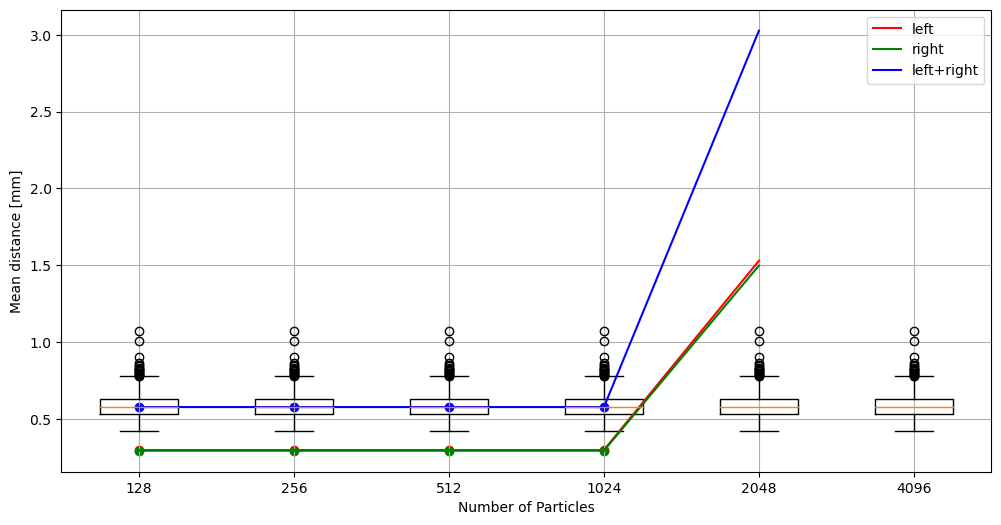

In [175]:
# plt.figure(figsize=(12,6))
fig, ax = plt.subplots(figsize=(12,6))

plt.scatter(1, mean_dist_left_128, c="r")
plt.scatter(1, mean_dist_right_128, c="g")
plt.scatter(1, np.median(mean_dist_overall_128), c="b")
plt.scatter(2, mean_dist_left_256, c="r")
plt.scatter(2, mean_dist_right_256, c="g")
plt.scatter(2, np.median(mean_dist_overall_256), c="b")
plt.scatter(3, mean_dist_left_512, c="r")
plt.scatter(3, mean_dist_right_512, c="g")
plt.scatter(3, np.median(mean_dist_overall_512),c="b")
plt.scatter(4, mean_dist_left_1024, c="r")
plt.scatter(4, mean_dist_right_1024, c="g")
plt.scatter(4, np.median(mean_dist_overall_1024), c="b")
# plt.scatter(5, mean_dist_left_2048, c="r")
# plt.scatter(5, mean_dist_right_2048, c="g")
# plt.scatter(5, np.median(mean_dist_overall_2048), c="b")
# plt.scatter(6, mean_dist_left_4096, c="r")
# plt.scatter(6, mean_dist_right_4096, c="g")
# plt.scatter(6, np.median(mean_dist_overall_4096), c="b")

my_dict = {"128": mean_dist_overall_128, 
           "256": mean_dist_overall_256,
           "512": mean_dist_overall_512,
           "1024": mean_dist_overall_1024,
           "2048": mean_dist_overall_1024,
           "4096": mean_dist_overall_1024}

ax.boxplot(my_dict.values())

plt.plot([1,2,3,4,5], [mean_dist_left_128, mean_dist_left_256, mean_dist_left_512, mean_dist_left_1024, mean_dist_left_2048], c='r', label="left")
plt.plot([1,2,3,4,5], [mean_dist_right_128, mean_dist_right_256, mean_dist_right_512, mean_dist_right_1024, mean_dist_right_2048], c='g', label="right")
plt.plot([1,2,3,4,5], [np.median(mean_dist_overall_128), np.median(mean_dist_overall_256), np.median(mean_dist_overall_512), np.median(mean_dist_overall_1024), np.median(mean_dist_overall_2048)], c='b', label="left+right")

plt.xlabel("Number of Particles")
plt.ylabel("Mean distance [mm]")
plt.xticks([1, 2, 3, 4, 5, 6], [128, 256, 512, 1024, 2048, 4096])
plt.legend()
plt.grid(True)
plt.show()